In [1]:
# CODE CREDS: Literally our HW assignments

# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/cs231n_final_proj/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
[Errno 2] No such file or directory: '/content/drive/My Drive/cs231n/cs231n_final_proj//cs231n/datasets/'
/content
bash: get_datasets.sh: No such file or directory
/content/drive/My Drive/cs231n/cs231n_final_proj


In [2]:
!pip install pydicom

import pandas as pd
import numpy as np
from scipy import ndimage
import os
import pydicom
from tqdm import tqdm_notebook
import matplotlib.pylab as plt
%matplotlib inline

     |████████████████████████████████| 1.9MB 3.8MB/s 


In [3]:
data_path = '/content/drive/MyDrive/cs231n/cs231n_final_proj/stage_2_train/'
metadata_path = data_path
label_path = '/content/drive/MyDrive/cs231n/cs231n_final_proj/stage_2_train.csv'

(512, 512)


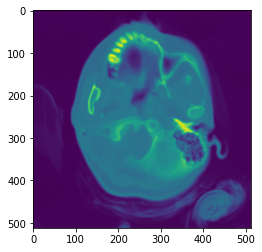

In [5]:
# Try visualizing one image
image_path = data_path + 'ID_0edba8245.dcm'
ds = pydicom.dcmread(image_path)

plt.imshow(ds.pixel_array)
print(ds.pixel_array.shape)

name, extension = os.path.splitext(image_path)

Some things we might have to do:

* [DONE] Delete duplicates (look into .drop_duplicates())

* [Nah] Remove blank images (https://www.kaggle.com/jesdin/find-blank-images-in-dataset) though I'm not sure if blank images help all the patients have same number of slices?? But prob not?

* [DONE] Each .dcm file is only one 2D slice, we need to collect the slices from each patient together into a 3D volume. (https://www.kaggle.com/anjum48/reconstructing-3d-volumes-from-metadata)
Still need to deal with images having different number of slices. Should we just pad it? (https://stackoverflow.com/questions/58115013/how-to-pad-multiple-images-to-the-minimum-shape-containing-them-all) Spline interpolation (to "fill in" gaps)? (https://keras.io/examples/vision/3D_image_classification/#:~:text=A%203D%20CNN%20is%20simply,learning%20representations%20for%20volumetric%20data.)




First, let's try to read in all of the images and group images together per patient.

In: Raw data

Out: A 3D numpy array, normalized, per patient, using the B&W filter

CODE CREDS: Adapted from this Kaggle notebook https://www.kaggle.com/anjum48/reconstructing-3d-volumes-from-metadata

In [4]:
# Prepare labels and metadata
# i.e. for each image, is there any ICH, or ICH of specific type
train_df = pd.read_csv(f'{label_path}').drop_duplicates()
train_df['ImageID'] = train_df['ID'].str.slice(stop=12)
train_df['Diagnosis'] = train_df['ID'].str.slice(start=13)
train_labels = train_df.pivot(index="ImageID", columns="Diagnosis", values="Label")

In [7]:
train_labels.head(100)

Diagnosis,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
ImageID,,,,,,
ID_000012eaf,0,0,0,0,0,0
ID_000039fa0,0,0,0,0,0,0
ID_00005679d,0,0,0,0,0,0
ID_00008ce3c,0,0,0,0,0,0
ID_0000950d7,0,0,0,0,0,0
...,...,...,...,...,...,...
ID_0008bccec,0,0,0,0,0,0
ID_0008d8433,1,0,0,0,1,0
ID_0008e5e43,0,0,0,0,0,0


In [7]:
# Function to get the metadata of all the DCM files given the directory
def get_metadata(image_dir):

    # Set up the metadata dictionary for all images
    labels = [
        'BitsAllocated', 'BitsStored', 'Columns', 'HighBit', 
        'ImageOrientationPatient_0', 'ImageOrientationPatient_1', 'ImageOrientationPatient_2',
        'ImageOrientationPatient_3', 'ImageOrientationPatient_4', 'ImageOrientationPatient_5',
        'ImagePositionPatient_0', 'ImagePositionPatient_1', 'ImagePositionPatient_2',
        'Modality', 'PatientID', 'PhotometricInterpretation', 'PixelRepresentation',
        'PixelSpacing_0', 'PixelSpacing_1', 'RescaleIntercept', 'RescaleSlope', 'Rows', 'SOPInstanceUID',
        'SamplesPerPixel', 'SeriesInstanceUID', 'StudyID', 'StudyInstanceUID', 
        'WindowCenter', 'WindowWidth', 'Image',
    ]

    data = {l: [] for l in labels} # like {'BitsAllocated': [], 'BitsStored': [], etc.}

    # Update the metadata for all DCM files
    for image in tqdm_notebook(os.listdir(image_dir)): # for each image
      
      name, extension = os.path.splitext(image) # check if file is a DCM file (addded by JZ)
      if extension == '.dcm': # if it is, then:

        data["Image"].append(image[:-4]) # append image id
        ds = pydicom.dcmread(os.path.join(image_dir, image)) # read the whole DCM file

        # update metadata
        for metadata in ds.dir():
            if metadata != "PixelData":
                metadata_values = getattr(ds, metadata) # get value of each metadata param
                if type(metadata_values) == pydicom.multival.MultiValue and metadata not in ["WindowCenter", "WindowWidth"]:
                    for i, v in enumerate(metadata_values):
                        data[f"{metadata}_{i}"].append(v) # update metadata value in dict
                else:
                    if type(metadata_values) == pydicom.multival.MultiValue and metadata in ["WindowCenter", "WindowWidth"]:
                        data[metadata].append(metadata_values[0])
                    else:
                        data[metadata].append(metadata_values)

    return pd.DataFrame(data).set_index("Image")

In [9]:
# Generate metadata dataframes (only have to do this once, since it takes a while)
train_metadata = get_metadata(data_path)
train_metadata.to_parquet(f'{data_path}/train_metadata.parquet.gzip', compression='gzip')

#test_metadata = get_metadata(os.path.join(data_path, "test_images"))
#test_metadata.to_parquet(f'{data_path}/test_metadata.parquet.gzip', compression='gzip')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [64]:
# Join the image metadata with the outcome labels

train_metadata = pd.read_parquet(f'{metadata_path}/train_metadata.parquet.gzip')
#test_metadata = pd.read_parquet(f'{metadata_path}/test_metadata.parquet.gzip')

train_metadata["Dataset"] = "train"
#test_metadata["Dataset"] = "test"
train_metadata = train_metadata.join(train_labels)

#metadata = pd.concat([train_metadata, test_metadata], sort=True)
metadata = train_metadata

metadata.sort_values(by="ImagePositionPatient_2", inplace=True, ascending=False) # sort so images in order
metadata.head()

,BitsAllocated,BitsStored,Columns,HighBit,ImageOrientationPatient_0,ImageOrientationPatient_1,ImageOrientationPatient_2,ImageOrientationPatient_3,ImageOrientationPatient_4,ImageOrientationPatient_5,ImagePositionPatient_0,ImagePositionPatient_1,ImagePositionPatient_2,Modality,PatientID,PhotometricInterpretation,PixelRepresentation,PixelSpacing_0,PixelSpacing_1,RescaleIntercept,RescaleSlope,Rows,SOPInstanceUID,SamplesPerPixel,SeriesInstanceUID,StudyID,StudyInstanceUID,WindowCenter,WindowWidth,Dataset,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
Image,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ID_0ed67de98,16,12,512,11,1.0,0.0,0.0,0.0,0.974370,-0.224951,-125.0,18.951102,1699.67778,CT,ID_1a6a5070,MONOCHROME2,0,0.488281,0.488281,-1000.0,1.0,512,ID_0ed67de98,1,ID_837aa869c3,,ID_29caa5f6fe,40.0,80.0,train,0,0,0,0,0,0
ID_0e4033f91,16,12,512,11,1.0,0.0,0.0,0.0,0.920505,-0.390731,-139.5,-5.612284,1673.74897,CT,ID_802f9283,MONOCHROME2,1,0.544922,0.544922,0.0,1.0,512,ID_0e4033f91,1,ID_3db28400e8,,ID_49e160366d,40.0,80.0,train,0,0,0,0,0,0
ID_0e77d6fcc,16,12,512,11,1.0,0.0,0.0,0.0,0.974370,-0.224951,-125.0,3.049529,1671.36404,CT,ID_4c3dea53,MONOCHROME2,0,0.488281,0.488281,-1000.0,1.0,512,ID_0e77d6fcc,1,ID_c56d806e01,,ID_b3b2f5ae57,40.0,80.0,train,0,0,0,0,0,0
ID_0e89a1925,16,12,512,11,1.0,0.0,0.0,0.0,0.927184,-0.374607,-125.0,23.393283,1665.11217,CT,ID_35c1cb3b,MONOCHROME2,0,0.488281,0.488281,-1000.0,1.0,512,ID_0e89a1925,1,ID_57ea76917d,,ID_0c71eb0611,40.0,80.0,train,0,0,0,0,0,0
ID_0e69242e4,16,12,512,11,1.0,0.0,0.0,0.0,0.920505,-0.390731,-173.5,-26.207026,1656.01276,CT,ID_362cf84d,MONOCHROME2,0,0.677734,0.677734,-1000.0,1.0,512,ID_0e69242e4,1,ID_44110b5f6c,,ID_6222a3935b,40.0,80.0,train,0,0,0,0,0,0


In [ ]:
# Num unique studies (scans)
print("There are ", metadata["StudyInstanceUID"].nunique(), " CT scans in the whole dataset.")

In [66]:
# Subsample the scans (get study IDs)
n_normal = 200
n_ICH_epidural = 20
n_ICH_intraparenchymal = 20
n_ICH_intraventricular = 20
n_ICH_subarachnoid = 20
n_ICH_subdural = 20

outcome_types = ["any", "epidural", "intraparenchymal", "intraventricular", "subarachnoid", "subdural"]
outcome_sampsizes = [n_normal, n_ICH_epidural, n_ICH_intraparenchymal, n_ICH_intraventricular, n_ICH_subarachnoid, n_ICH_subdural]
study_outcomes = metadata[["StudyInstanceUID"] + outcome_types].drop_duplicates()

studyIDs = []
for status, n in zip(outcome_types, outcome_sampsizes):
  # Sample some number of unique scans per outcome
  if status == "any": # normal
    new_studyIDs = list(np.random.choice(study_outcomes[study_outcomes[status] == 0]["StudyInstanceUID"].unique(), n))
  else: # not normal (ICH)
    new_studyIDs = list(np.random.choice(study_outcomes[study_outcomes[status] == 1]["StudyInstanceUID"].unique(), n))
  
  studyIDs += new_studyIDs

print(len(studyIDs))
print(studyIDs)

300
['ID_4555a71e93', 'ID_aca03293ea', 'ID_cb38336d7d', 'ID_3d361c6f19', 'ID_f6810e93d6', 'ID_649590ef34', 'ID_1e531082f7', 'ID_34c5fad296', 'ID_250a2665f4', 'ID_08474ce686', 'ID_ff285cf968', 'ID_5da2f2800f', 'ID_3f7a5559a8', 'ID_45ba3413e9', 'ID_dbc00de9cf', 'ID_e2f2bcfe32', 'ID_341ce182ed', 'ID_5738f2710d', 'ID_918dd61bde', 'ID_4136e073e1', 'ID_df1c674b87', 'ID_6a7b2d0cb9', 'ID_4fe7ed7a77', 'ID_596dc0fd64', 'ID_1f4e1aec67', 'ID_e0f984c5f7', 'ID_7a135dffdd', 'ID_a22e05addf', 'ID_af57da462b', 'ID_b2ffaa77fd', 'ID_d3100c82d3', 'ID_90fdbc4b5d', 'ID_262b66ac35', 'ID_1be5787a12', 'ID_567f900afd', 'ID_61bf18f07a', 'ID_798ad11a1f', 'ID_ab3e6b2cc3', 'ID_75471a9d44', 'ID_9368cdf001', 'ID_572270ebd1', 'ID_69c03f2854', 'ID_a542fab9c9', 'ID_01a3c77ba5', 'ID_74f04b869a', 'ID_0511d88e94', 'ID_2889ddbc33', 'ID_edc717ceab', 'ID_efa73616af', 'ID_3475f703b0', 'ID_d0bd3a5963', 'ID_d1c6e63009', 'ID_702634d2c7', 'ID_374d4f60c9', 'ID_e9f953df47', 'ID_261b63a51a', 'ID_13b3cdfaca', 'ID_494156fc7d', 'ID_3712f

In [67]:
# Subsample the scans (subset the dataframe)
metadata = metadata[metadata['StudyInstanceUID'].isin(studyIDs)]

In [89]:
# Group together all images per scan
studies = metadata.groupby("StudyInstanceUID")#.size().sort_values(ascending=False)
print(studies.size().describe())
#print(studies)

count    283.000000
mean       1.183746
std        0.455250
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        4.000000
dtype: float64


In [69]:
studies_list = list(studies)
print(studies_list[:5])

[('ID_008975a08a',               BitsAllocated  BitsStored  ...  subarachnoid  subdural
Image                                    ...                        
ID_0eb92a230             16          12  ...             0         0

[1 rows x 36 columns]), ('ID_0136ebaa38',               BitsAllocated  BitsStored  ...  subarachnoid  subdural
Image                                    ...                        
ID_0e137abb2             16          16  ...             0         0

[1 rows x 36 columns]), ('ID_01a3c77ba5',               BitsAllocated  BitsStored  ...  subarachnoid  subdural
Image                                    ...                        
ID_0a36fc5f6             16          16  ...             1         0
ID_0a8447585             16          16  ...             1         0
ID_0e69fc170             16          16  ...             0         0

[3 rows x 36 columns]), ('ID_01c5d0fcf5',               BitsAllocated  BitsStored  ...  subarachnoid  subdural
Image                   

In [70]:
print(studies_list[0][0]) # just showing how to get a scan image ID

ID_008975a08a


In [72]:
# Show one group of images with > 1 slice
idx = next((i for i, x in enumerate(studies_list) if x[0] == 'ID_f765cb61ee'), None) # get index of chosen study instance
study_name, study_df = studies_list[idx] # Study instance ID, image IDs and attributes under that study instance
print(study_name)
study_df.head()

ID_f765cb61ee


,BitsAllocated,BitsStored,Columns,HighBit,ImageOrientationPatient_0,ImageOrientationPatient_1,ImageOrientationPatient_2,ImageOrientationPatient_3,ImageOrientationPatient_4,ImageOrientationPatient_5,ImagePositionPatient_0,ImagePositionPatient_1,ImagePositionPatient_2,Modality,PatientID,PhotometricInterpretation,PixelRepresentation,PixelSpacing_0,PixelSpacing_1,RescaleIntercept,RescaleSlope,Rows,SOPInstanceUID,SamplesPerPixel,SeriesInstanceUID,StudyID,StudyInstanceUID,WindowCenter,WindowWidth,Dataset,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
Image,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ID_0afc7342e,16,12,512,11,1.0,0.0,0.0,0.0,1.0,0.0,-112.064014,-8.953288,256.800049,CT,ID_d41d9376,MONOCHROME2,0,0.451172,0.451172,-1024.0,1.0,512,ID_0afc7342e,1,ID_7215d54263,,ID_f765cb61ee,36.0,80.0,train,0,0,0,0,0,0
ID_0a986c960,16,12,512,11,1.0,0.0,0.0,0.0,1.0,0.0,-112.064014,-8.953288,186.800049,CT,ID_d41d9376,MONOCHROME2,0,0.451172,0.451172,-1024.0,1.0,512,ID_0a986c960,1,ID_7215d54263,,ID_f765cb61ee,36.0,80.0,train,0,0,0,0,0,0
ID_0a92118b8,16,12,512,11,1.0,0.0,0.0,0.0,1.0,0.0,-112.064014,-8.953288,166.800049,CT,ID_d41d9376,MONOCHROME2,0,0.451172,0.451172,-1024.0,1.0,512,ID_0a92118b8,1,ID_7215d54263,,ID_f765cb61ee,36.0,80.0,train,0,0,0,0,0,0
ID_0ed9d153c,16,12,512,11,1.0,0.0,0.0,0.0,1.0,0.0,-112.064014,-8.953288,121.800049,CT,ID_d41d9376,MONOCHROME2,0,0.451172,0.451172,-1024.0,1.0,512,ID_0ed9d153c,1,ID_7215d54263,,ID_f765cb61ee,36.0,80.0,train,0,0,0,0,0,0


(array([238.,   0.,   0.,  39.,   0.,   0.,   5.,   0.,   0.,   1.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

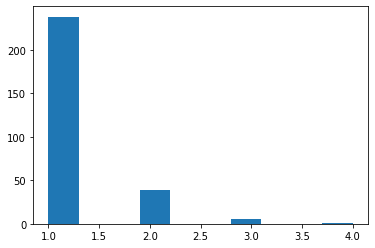

In [76]:
# Plot distribution of num slices per patient
plt.hist(studies)

In [77]:
# Keep just the patients with >1 slices (remove this for full dataset)
studies_list_mult = [study for study in studies_list if study[1].shape[0] > 1]

In [78]:
# CODE CREDS (for windowing fn): https://www.kaggle.com/wfwiggins203/eda-dicom-tags-windowing-head-cts

# Windowing function (the BW filter)
def window_img(dcm, width=None, level=None, norm=True):
    pixels = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    
    # Pad non-square images
    if pixels.shape[0] != pixels.shape[1]:
        (a,b) = pixels.shape
        if a > b:
            padding = ((0, 0), ((a-b) // 2, (a-b) // 2))
        else:
            padding = (((b-a) // 2, (b-a) // 2), (0, 0))
        pixels = np.pad(pixels, padding, mode='constant', constant_values=0)
            
    if not width:
        width = dcm.WindowWidth
        if type(width) != pydicom.valuerep.DSfloat:
            width = width[0]
    if not level:
        level = dcm.WindowCenter # center
        if type(level) != pydicom.valuerep.DSfloat:
            level = level[0]
    lower = level - (width / 2) # lower boundary
    upper = level + (width / 2) # upper boundary
    img = np.clip(pixels, lower, upper)
    
    if norm:
        return (img - lower) / (upper - lower) # normalization
    else:
        return img

In [79]:
# Function to create a 3D volume per group of slices 
# Returns normalized numpy arrays holding each slice and associated labels
# (adapted by JZ into function)
def create_3D_volume(study_df):
  volume, labels = [], []
  
  # Iterate over all slices in study (index = slice index, row = slice info)
  for index, row in study_df.iterrows():

      # Read the DCM file
      if row["Dataset"] == "train":
          dcm = pydicom.dcmread(os.path.join(data_path, index + ".dcm"))
      #else:
      #    dcm = pydicom.dcmread(os.path.join(data_path, "stage_1_test_images", index+".dcm"))
      
      # Get image & 0/1 labels per category
      img = window_img(dcm)
      label = row[["any", "epidural", "intraparenchymal", "intraventricular", "subarachnoid", "subdural"]]
      
      volume.append(img)
      labels.append(label)
      
  volume = np.array(volume)
  labels = np.array(labels)

  # Consolidate labels for each 3D volume -- binary 0/1 of whether any or each of 5 types of ICH present
  labels = (np.sum(labels, axis = 0) > 1) - 0

  return volume, labels

In [80]:
# Apply to one image to check if function works
volume, labels = create_3D_volume(study_df)
print(volume.shape)
print(labels.shape)

(4, 512, 512)
(6,)


Text(0.5, 1.0, 'Slice 4')

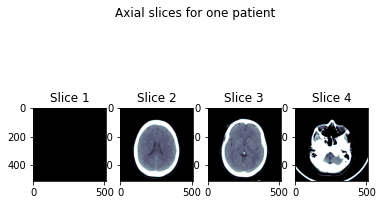

In [81]:
# Axial slices 
#(adapted by JZ)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.suptitle('Axial slices for one patient')

ax1.imshow(volume[0, :, :], cmap=plt.cm.bone)
ax1.set_title('Slice 1') # top
ax2.imshow(volume[1, :, :], cmap=plt.cm.bone)
ax2.set_title('Slice 2')
ax3.imshow(volume[2, :, :], cmap=plt.cm.bone)
ax3.set_title('Slice 3')
ax4.imshow(volume[3, :, :], cmap=plt.cm.bone)
ax4.set_title('Slice 4') #bottom

In [82]:
len(studies_list_mult) # how many studies are we dealing with?

45

In [83]:
# Create 3D volumes for all the scans (w/ >1 slice) 
# Keep track of largest dimensions for interpolation later on
#(JZ wrote this part)
study_names_all = []
volumes_all = []
labels_all = []

largest_depth = 0
largest_width = 0
largest_height = 0

for i in range(len(studies_list_mult)):
  if i % 100 == 0:
    print("On scan #" + str(i+1))

  # Get study
  study_name, study_df = studies_list_mult[i]

  # Create 3D volume
  volume, labels = create_3D_volume(study_df)

  # Store results
  study_names_all.append(study_name)
  volumes_all.append(volume)
  labels_all.append(labels)

  # Update largest depth, width, height
  shape = volume.shape
  if shape[0] > largest_depth:
    largest_depth = shape[0]
  if shape[1] > largest_width:
    largest_width = shape[1]
  if shape[2] > largest_height:
    largest_height = shape[2]

print("DONE!")
print("Largest depth, width, height are: " + str(largest_depth) + ", " + str(largest_width) + ", " + str(largest_height))

On scan #1
DONE!
Largest depth, width, height are: 4, 512, 512


Next, let's try to spline-interpolate the data with less slices to get everything into the same sizes.

In: one 3D numpy array per patient, possibly of various sizes

Out: one 3D numpy array per patient, all the same size

Ref: https://keras.io/examples/vision/3D_image_classification/#:~:text=A%203D%20CNN%20is%20simply,learning%20representations%20for%20volumetric%20data.

In [84]:
# Function to resize an image via spline interpolation
def resize_volume(img, d, w, h):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = d 
    desired_width = w #512
    desired_height = h #512
    # Get current depth
    current_depth = img.shape[0]
    current_width = img.shape[1]
    current_height = img.shape[2]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate -- don't think we need to do this...?
    #img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (depth_factor, width_factor, height_factor), order=1) # linear spline interpolation
    return img

In [85]:
volumes_all_interp = []
for i in range(len(volumes_all)):
  if i % 100 == 0:
    print("On scan #" + str(i+1))

  resized_volume = resize_volume(volumes_all[i], largest_depth, largest_width, largest_height)
  volumes_all_interp.append(resized_volume)

print("DONE!")

On scan #1
DONE!


In [86]:
volumes_all_interp[2].shape

(4, 512, 512)

Text(0.5, 1.0, 'Slice 4')

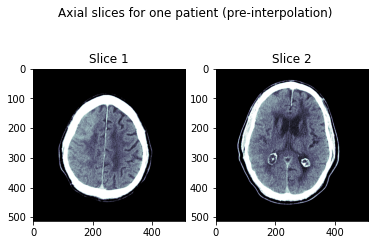

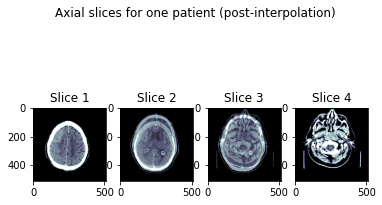

In [87]:
# Visualize the interpolation
# before
volume = volumes_all[0]
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Axial slices for one patient (pre-interpolation)')

ax1.imshow(volume[0, :, :], cmap=plt.cm.bone)
ax1.set_title('Slice 1') # top
ax2.imshow(volume[1, :, :], cmap=plt.cm.bone)
ax2.set_title('Slice 2') #bottom

# after
volume = volumes_all_interp[0]
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.suptitle('Axial slices for one patient (post-interpolation)')

ax1.imshow(volume[0, :, :], cmap=plt.cm.bone)
ax1.set_title('Slice 1') # top
ax2.imshow(volume[1, :, :], cmap=plt.cm.bone)
ax2.set_title('Slice 2')
ax3.imshow(volume[2, :, :], cmap=plt.cm.bone)
ax3.set_title('Slice 3')
ax4.imshow(volume[3, :, :], cmap=plt.cm.bone)
ax4.set_title('Slice 4') #bottom


# Some exploratory analysis

Should probably check balance in data...

In [108]:
while True:
  pass

KeyboardInterrupt: ignored